# Hierarchical exponential growth model

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pints
import seaborn as sns
sns.set_theme()

The data-generating model is a hierarchical exponential growth model governed
by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (y_0, \lambda, \sigma)$ and
$\theta = (\mu_{y_0}, \mu_{\lambda}, \sigma_{y_0}, \sigma_{\lambda}, \theta_{\sigma})$.
The measurements of individuals is governed by the mechanistic model-error
model pair

$$
    p(y | \psi , t) = \mathcal{N}(y | y_0\mathrm{e}^{\lambda t}, \sigma ^2),
$$

and the inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(y_0 | \mu_{y_0}, \sigma ^2_{y_0})\,
        \mathcal{N}(\lambda | \mu_{\lambda}, \sigma ^2_{\lambda})\,
        \delta (\sigma - \theta_{\sigma}).
$$

## Define data-generating model

In [78]:
class ToyExponentialGrowthModel(chi.MechanisticModel):
    """
    A toy exponential growth model.
    """
    def __init__(self):
        super(ToyExponentialGrowthModel, self).__init__()

        self._has_sensitivities = False

    def enable_sensitivities(self, enabled, parameter_names=None):
        r"""
        Enables the computation of the model output sensitivities to the model
        parameters if set to ``True``.

        The sensitivities of the model outputs are defined as the partial
        derviatives of the ouputs :math:`\bar{y}` with respect to the model
        parameters :math:`\psi`

        .. math:
            \frac{\del \bar{y}}{\del \psi}.

        :param enabled: A boolean flag which enables (``True``) / disables
            (``False``) the computation of sensitivities.
        :type enabled: bool
        """
        self._has_sensitivities = bool(enabled)

    def has_sensitivities(self):
        """
        Returns a boolean indicating whether sensitivities have been enabled.
        """
        return self._has_sensitivities

    def n_outputs(self):
        """
        Returns the number of output dimensions.

        By default this is the number of states.
        """
        return 1

    def n_parameters(self):
        """
        Returns the number of parameters in the model.

        Parameters of the model are initial state values and structural
        parameter values.
        """
        return 2

    def outputs(self):
        """
        Returns the output names of the model.
        """
        return ['Count']

    def parameters(self):
        """
        Returns the parameter names of the model.
        """
        return ['Initial count', 'Growth rate']

    def simulate(self, parameters, times):
        """
        Returns the numerical solution of the model outputs (and optionally
        the sensitivites) for the specified parameters and times.

        The model outputs are returned as a 2 dimensional NumPy array of shape
        ``(n_outputs, n_times)``. If sensitivities are enabled, a tuple is
        returned with the NumPy array of the model outputs and a NumPy array of
        the sensitivities of shape ``(n_times, n_outputs, n_parameters)``.

        :param parameters: An array-like object with values for the model
            parameters.
        :type parameters: list, numpy.ndarray
        :param times: An array-like object with time points at which the output
            values are returned.
        :type times: list, numpy.ndarray

        :rtype: np.ndarray of shape (n_outputs, n_times) or
            (n_times, n_outputs, n_parameters)
        """
        y0, growth_rate = parameters
        times = np.asarray(times)

        # Solve model
        y = y0 * np.exp(growth_rate * times)

        if not self._has_sensitivities:
            return y[np.newaxis, :]

        sensitivities = np.empty(shape=(len(times), 1, 2))
        sensitivities[:, 0, 0] = np.exp(growth_rate * times)
        sensitivities[:, 0, 1] = times * y

        return y[np.newaxis, :], sensitivities

# Data-generating parameters
population_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5,   # Std. exponential growth
    0.8]   # Sigma

## 0. Distributional shape of data-generating process over time

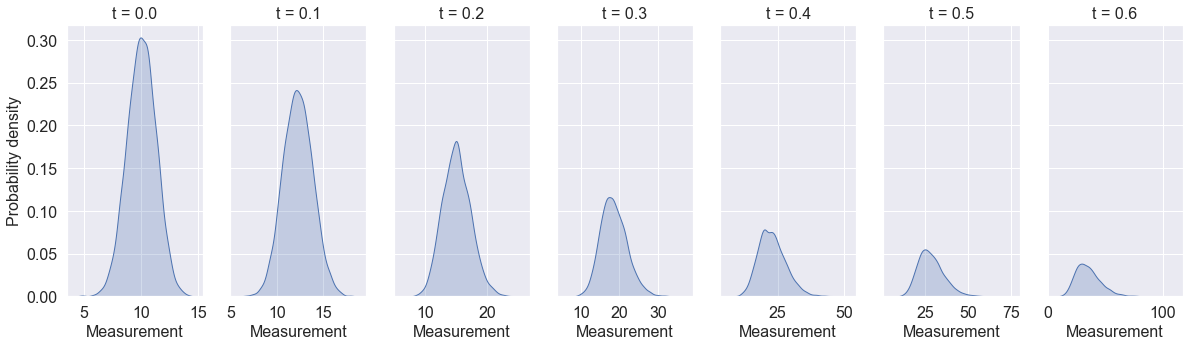

In [3]:
# Define data-generating model
mechanistic_model = ToyExponentialGrowthModel()
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Visualise distributions over time
fontsize = '16'
fig, axes = plt.subplots(
    1, len(times), figsize=(20, 5), sharey='row')
axes[0].set_ylabel('Probability density', fontsize=fontsize)
for tid, time in enumerate(times):
    # Add title and x-label to subfigure
    axes[tid].set_title('t = %.1f' % time, fontsize=fontsize)
    axes[tid].set_xlabel('Measurement', fontsize=fontsize)
    axes[tid].tick_params(labelsize=fontsize)

    # Plot KDE plot
    sns.kdeplot(
        x=measurements[0, tid], fill=True, linewidth=1, ax=axes[tid],
        legend=False)

plt.show()

## 1. 100 Individuals (non-snapshot data)

In [4]:
# Define data-generating model
mechanistic_model = ToyExponentialGrowthModel()
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 100
times = np.linspace(0, 0.6)
measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Swap axes for later convenience
measurements = np.moveaxis(
    measurements, source=(0, 1, 2), destination=(1, 2, 0))

fig = go.Figure()
for idx in range(n_ids):
    fig.add_trace(go.Scatter(
        x=times,
        y=measurements[idx, 0],
        mode='markers+lines',
        name='ID %d' % idx
    ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

### 1.1 Hierarchical inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     13     0.5      2        0:00.1
1     14     0.25     1        0:00.1
2     15     0.25     1        0:00.1
3     16     0.5      1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning:

overflow encountered in exp

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning:

overflow encountered in exp



20    109    0.781242 6        0:00.9
40    3097   0.768    143      0:25.2
60    6412   0.771    158      0:51.9
80    8952   0.762    121      1:12.0
100   11432  0.784    118      1:31.8
120   12838  0.69586  67       1:43.1
140   14322  0.791    71       1:54.9
160   15587  0.702    61       2:04.9
180   16783  0.734    57       2:14.4
200   17947  0.768    56       2:23.6
220   18919  0.758    47       2:31.3
240   20147  0.759    59       2:41.1
260   21271  0.718    54       2:50.1
280   22499  0.749    59       2:59.9
300   23695  0.765    57       3:09.5
320   24763  0.747    51       3:18.0
340   25991  0.760654 59       3:27.7
360   27091  0.764    53       3:36.4
380   28351  0.763    60       3:46.3
400   29355  0.742    48       3:54.3
420   30359  0.767    48       4:02.9
440   31427  0.758    51       4:11.9
460   32635  0.708    58       4:22.2
480   33959  0.775929 64       4:32.9
500   34995  0.766    50       4:41.2
520   36223  0.829    59       4:50.9
540   37483 

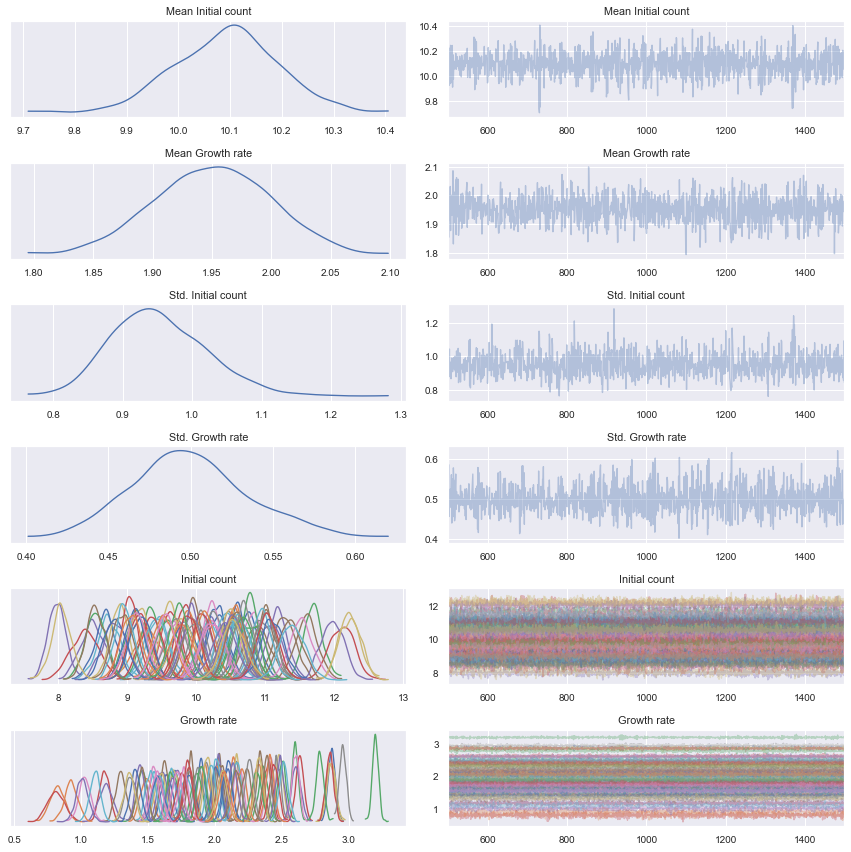

In [6]:
# Format data as dataframe
ids = np.arange(1, n_ids + 1)
n_times = len(times)
measurements_df = pd.DataFrame({
    'Observable': 'Count',
    'Value': measurements.flatten(),
    'ID': np.broadcast_to(ids[:, np.newaxis], (n_ids, n_times)).flatten(),
    'Time': np.broadcast_to(times[np.newaxis, :], (n_ids, n_times)).flatten()
})

# Define hierarchical log-posterior
population_model = chi.GaussianModel(
    n_dim=2, dim_names=['Initial count', 'Growth rate'])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(9, 3),        # Mean initial condition
    pints.GaussianLogPrior(5, 3),        # Mean exponential growth
    pints.LogNormalLogPrior(-0.1, 1),    # Std. initial condition
    pints.LogNormalLogPrior(-1, 1))      # Std. exponential growth
problem = chi.ProblemModellingController(mechanistic_model, error_model)
problem.fix_parameters({'Sigma': population_parameters[-1]})
problem.set_population_model(population_model)
problem.set_data(measurements_df)
problem.set_log_prior(log_prior)
log_posterior = problem.get_log_posterior()

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_hierarchical = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_hierarchical.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

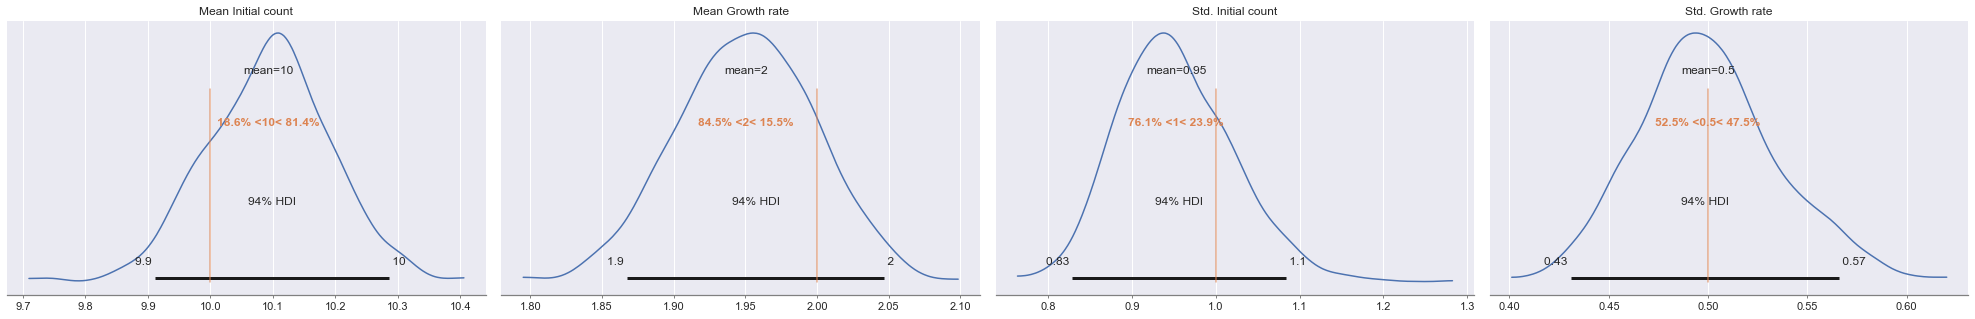

In [7]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_hierarchical.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Mean Initial count',
        'Mean Growth rate',
        'Std. Initial count',
        'Std. Growth rate'],
    ref_val=population_parameters)
plt.tight_layout()

### 1.2. Population filter inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     259    0.490695 128      0:00.6
1     290    0.25     16       0:00.6
2     353    0.327    32       0:00.8
3     480    0.496    64       0:01.0
20    3443   0.75     165      0:07.4
40    7354   0.762    187      0:15.7
60    11053  0.744    177      0:23.7
80    14629  0.761    171      0:31.4
100   17055  0.745    116      0:37.0
120   18410  0.714    65       0:39.8
140   19360  0.73739  46       0:42.1
160   20448  0.728    52       0:44.9
180   21403  0.753    46       0:47.0
200   22427  0.764    49       0:49.4
220   23484  0.735    51       0:51.8
240   24317  0.752    40       0:53.6
260   24991  0.721    32       0:55.1
280   26443  0.77     70       0:58.9
300   27269  0.743    40       1:01.1
320   28126  0.752    41       1:03.1
340   29130  0.763    48       1:05.6
360   29787  0.748    32       1:07.1
380   30727  0.775    45       1:09.1
400   31398  0.76 

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (56), generating only 20 plots



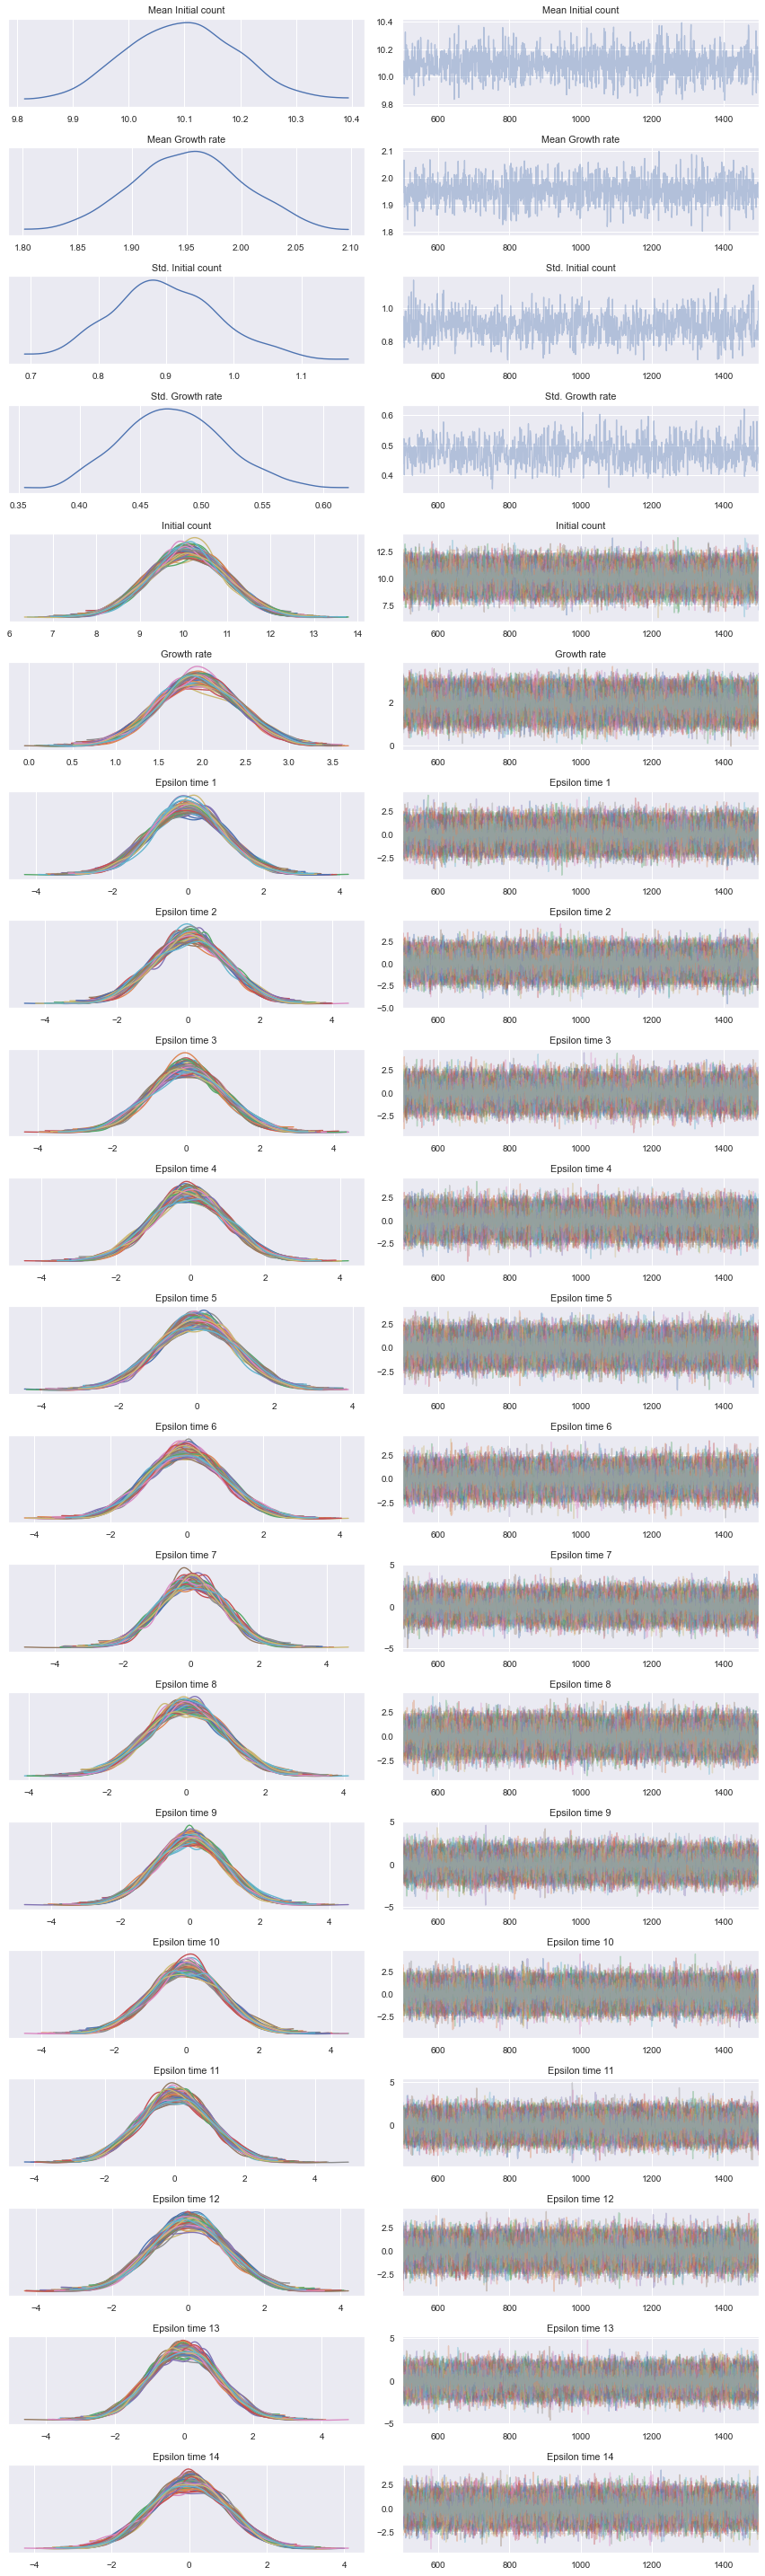

In [8]:
# Define population filter log-posterior
population_filter = chi.GaussianFilter(measurements)
pop_model = chi.GaussianModel(
    n_dim=2, dim_names=['Initial count', 'Growth rate'])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(9, 3),        # Mean initial condition
    pints.GaussianLogPrior(5, 3),        # Mean exponential growth
    pints.LogNormalLogPrior(-0.1, 1),    # Std. initial condition
    pints.LogNormalLogPrior(-1, 1))      # Std. exponential growth
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, pop_model, log_prior,
    sigma=population_parameters[-1])

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

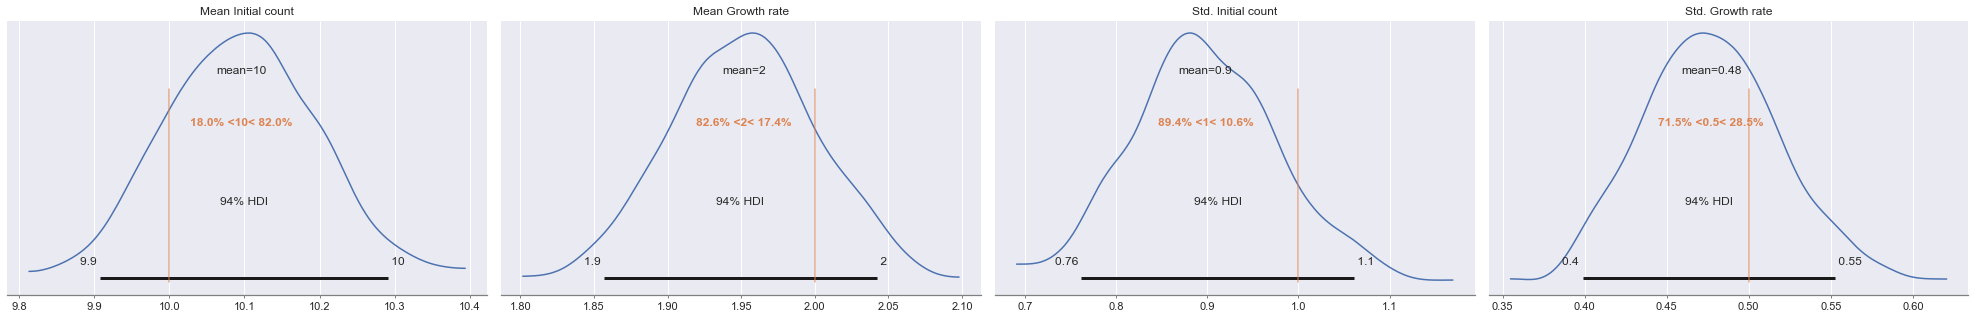

In [9]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Mean Initial count',
        'Mean Growth rate',
        'Std. Initial count',
        'Std. Growth rate'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

### Results

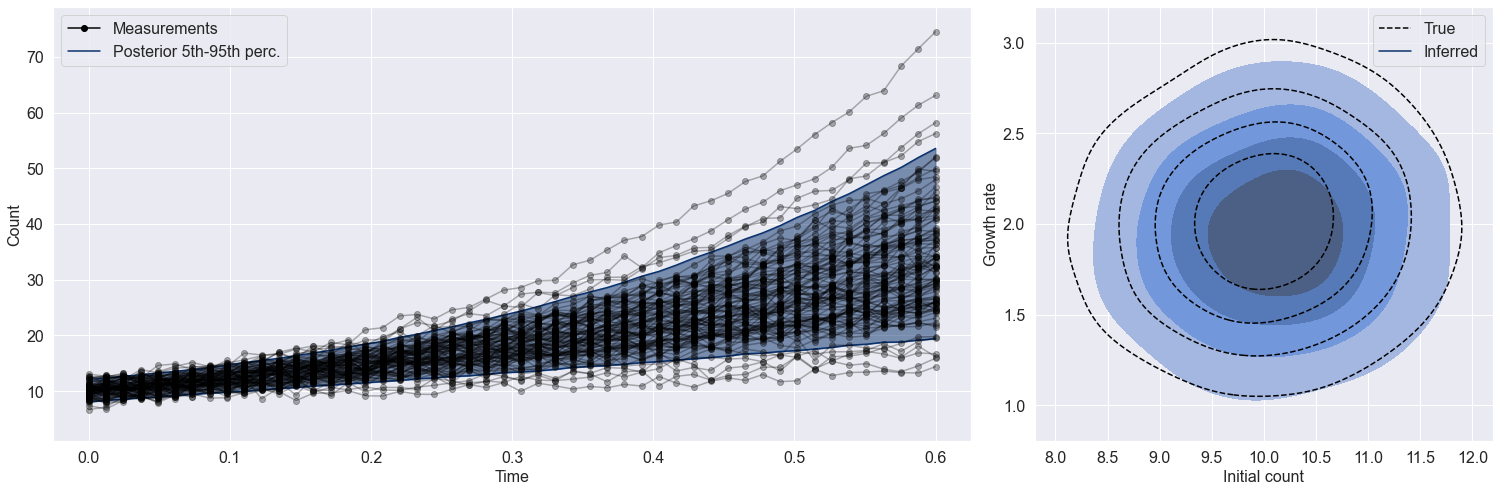

In [70]:
# Set up figure
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(21, 7), gridspec_kw={'width_ratios': [2, 1]})

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Mean Initial count'].values.flatten(),
    parameters['Mean Growth rate'].values.flatten(),
    parameters['Std. Initial count'].values.flatten(),
    parameters['Std. Growth rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 2))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[1])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 3))
parameters[:, :2] = samples
parameters[:, 2] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
axes[0].plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
axes[0].plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
axes[0].fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], linestyles='dashed', ax=axes[1])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    axes[0].plot(
        times, meas[0], color='black', marker='o', linestyle='solid',
        alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel('Count', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)
axes[0].plot(
    [100, 101], [100, 101], color='black', linestyle='solid', marker='o',
    label='Measurements')
axes[0].plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
axes[0].set_xlim([-0.025, 0.625])
axes[0].set_ylim([1, 79])
axes[1].plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
axes[1].plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
axes[1].set_xlim([7.8, 12.2])
axes[1].set_ylim([0.8, 3.2])
axes[1].set_xlabel('Initial count', fontsize=fontsize)
axes[1].set_ylabel('Growth rate', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)
axes[0].legend(fontsize=fontsize)
axes[1].legend(fontsize=fontsize)
plt.tight_layout()

## 1. 5000 Individuals (snapshot data)

In [79]:
# Define data-generating model
mechanistic_model = ToyExponentialGrowthModel()
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = np.linspace(0, 0.6)
dense_measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Keep only one measurement per individual (100 measurements per time point)
n_ids = 100
n_times = len(times)
n_observables = 1
measurements = np.empty(shape=(n_ids, n_observables, n_times))
for idt in range(n_times):
    start_ids = idt * n_ids
    end_ids = (idt + 1) * n_ids
    measurements[:, 0, idt] = dense_measurements[0, idt, start_ids:end_ids]

# Visualise measurements
fig = go.Figure()
for idt in range(n_times):
    for idx in range(n_ids):
        fig.add_trace(go.Scatter(
            x=[times[idt]],
            y=[measurements[idx, 0, idt]],
            mode='markers+lines',
            name='ID %d' % (idt + (n_times * idx))
        ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

### Population filter inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     259    0.491    128      0:00.6
1     290    0.5      16       0:00.7
2     295    0.167    3        0:00.7
3     332    0.39     19       0:00.8
20    4108   0.743    210      0:09.0
40    7389   0.737    157      0:15.7
60    11108  0.78     178      0:23.7
80    14160  0.758137 146      0:30.6
100   17169  0.759    144      0:36.8
120   18510  0.722    64       0:39.4
140   19592  0.745    52       0:41.9
160   20701  0.737    53       0:44.1
180   22118  0.755546 68       0:47.2
200   23138  0.757    49       0:49.2
220   24204  0.741    51       0:51.6
240   25194  0.777    48       0:53.6
260   26103  0.722    44       0:55.6
280   26796  0.748    33       0:57.2
300   27699  0.74     43       0:59.2
320   28716  0.770216 49       1:01.2
340   29683  0.764    47       1:03.3
360   30471  0.756    38       1:04.8
380   31347  0.775    42       1:06.8
400   32255  0.747

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (56), generating only 20 plots



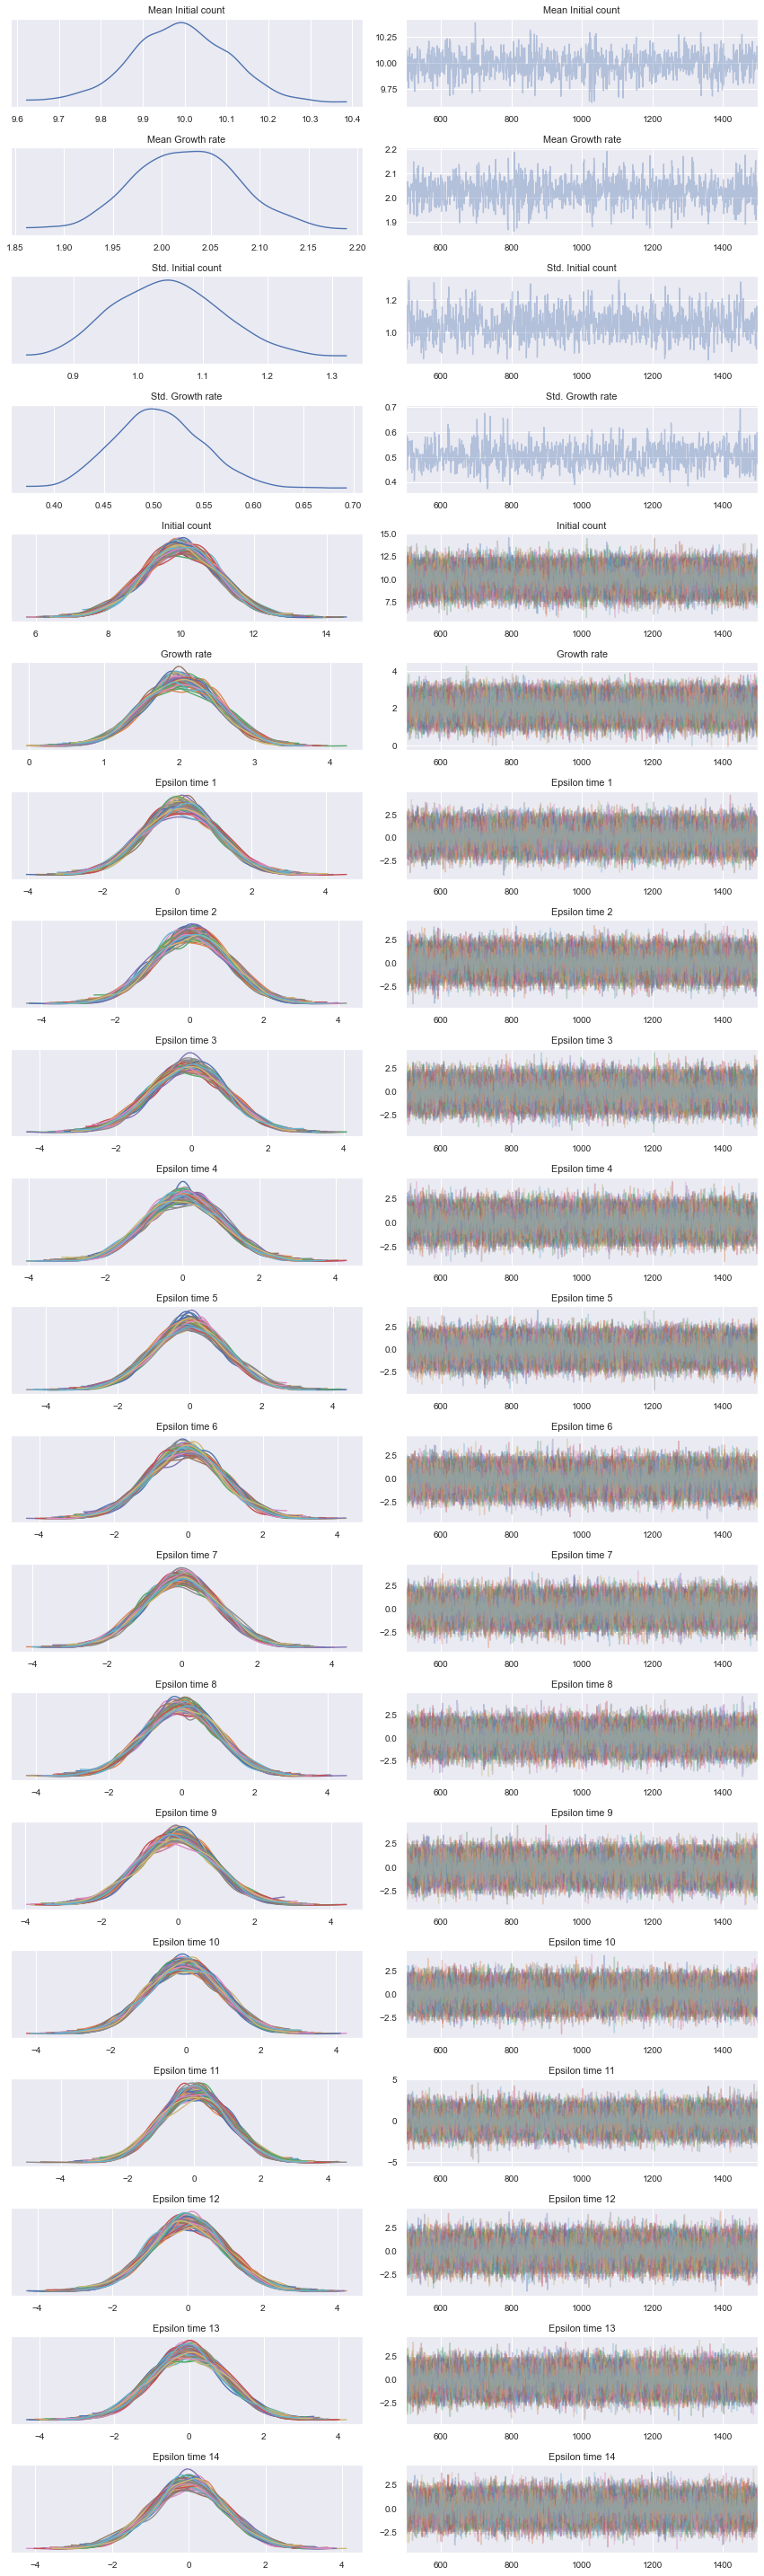

In [80]:
# Define population filter log-posterior
population_filter = chi.GaussianFilter(measurements)
population_model = chi.GaussianModel(
    n_dim=2, dim_names=['Initial count', 'Growth rate'])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(9, 3),        # Mean initial condition
    pints.GaussianLogPrior(5, 3),        # Mean exponential growth
    pints.LogNormalLogPrior(-0.1, 1),    # Std. initial condition
    pints.LogNormalLogPrior(-1, 1))      # Std. exponential growth
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1])

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

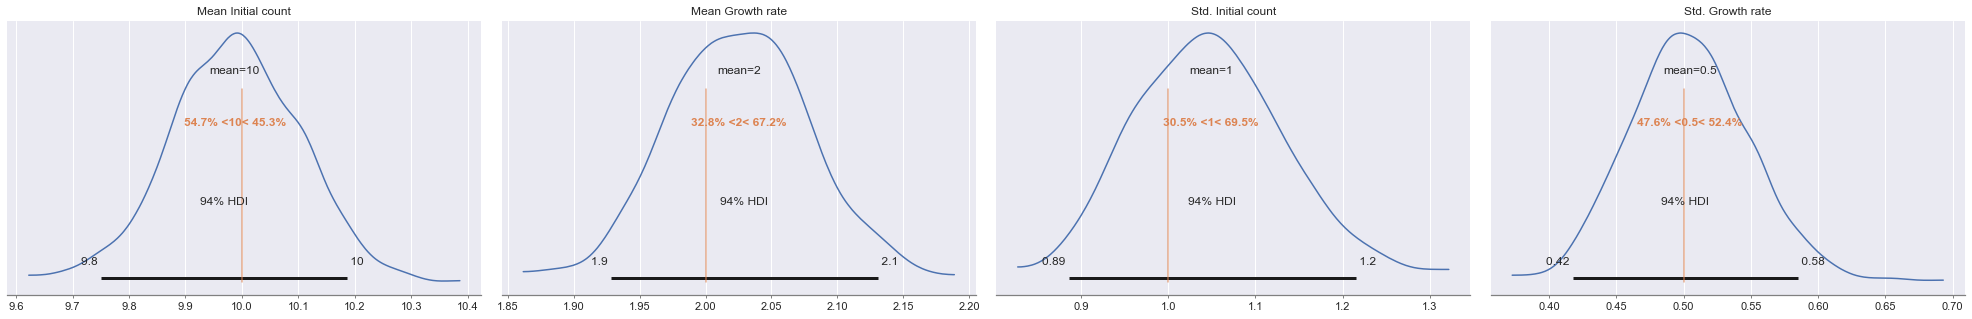

In [81]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Mean Initial count',
        'Mean Growth rate',
        'Std. Initial count',
        'Std. Growth rate'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

### Results

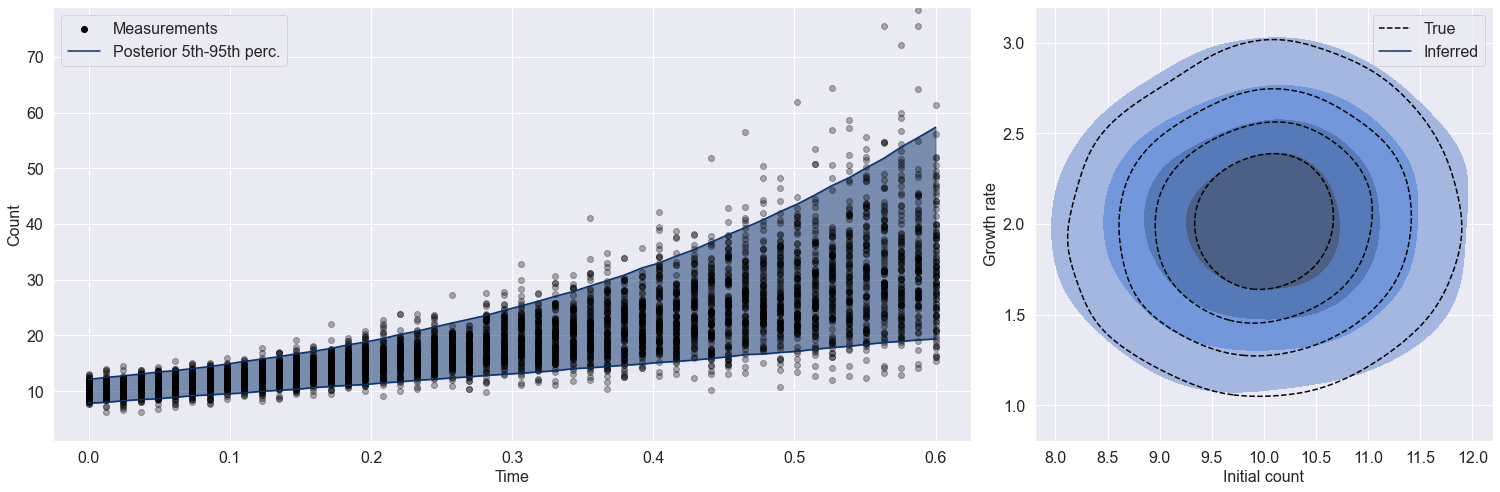

In [82]:
# Set up figure
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(21, 7), gridspec_kw={'width_ratios': [2, 1]})

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Mean Initial count'].values.flatten(),
    parameters['Mean Growth rate'].values.flatten(),
    parameters['Std. Initial count'].values.flatten(),
    parameters['Std. Growth rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 2))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[1])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 3))
parameters[:, :2] = samples
parameters[:, 2] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
axes[0].plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
axes[0].plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
axes[0].fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], linestyles='dashed', ax=axes[1])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    axes[0].scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel('Count', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)
axes[0].scatter(
    [100, 101], [100, 101], color='black', linestyle='solid', marker='o',
    label='Measurements')
axes[0].plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
axes[0].set_xlim([-0.025, 0.625])
axes[0].set_ylim([1, 79])
axes[1].plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
axes[1].plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
axes[1].set_xlim([7.8, 12.2])
axes[1].set_ylim([0.8, 3.2])
axes[1].set_xlabel('Initial count', fontsize=fontsize)
axes[1].set_ylabel('Growth rate', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)
axes[0].legend(fontsize=fontsize)
axes[1].legend(fontsize=fontsize)
plt.tight_layout()